In [ ]:
!pip install astra-toolbox imageio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cufft-cu12
    Found existing installation: nvidia-cufft-cu12 11.3.0.4
    Uninstalling nvidia-cufft-cu12-11.3.0.4:
      Successfully uninstalled nvidia-cufft-cu12-11.3.0.4
  Attempting uninstall: nvidia-cuda-runtime-cu12
    Found existing installation: nvidia-cuda-runtime-cu12 12.6.77
    Uninstalling nvidia-cuda-runtime-cu12-12.6.77:
      Successfully uninstalled nvidia-cuda-runtime-cu12-12.6.77
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires nvidia-cuda-runtime-cu12==12.6.77; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-ru

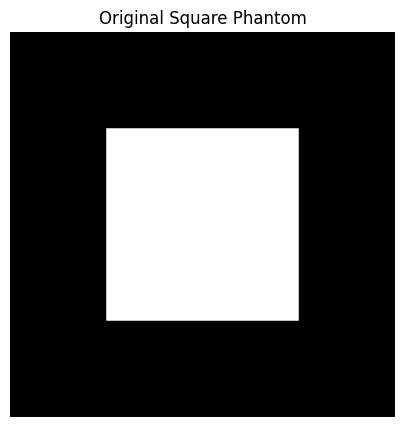

Using CUDA: False


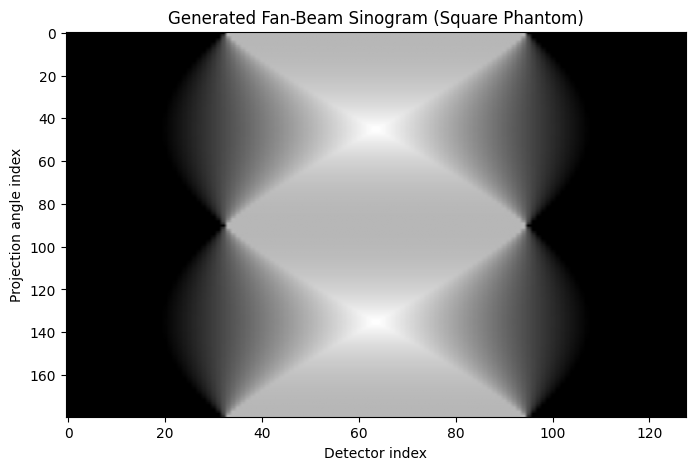

Sinogram saved to: sinograms_out/sinogram_square_fan.png
Done.


In [ ]:
# CT_sinogram_colab_astra_shapes.py
# Google Colab-ready script using only ASTRA toolbox to generate a 2D fan-beam sinogram
# from synthetic phantoms: square, triangle, or circle.
#
# Usage in Colab:
# !pip install astra-toolbox matplotlib numpy


import os
import math
import numpy as np
import astra
import matplotlib.pyplot as plt


# --------------------- Parameters --------------------
N_sensors = 128 # number of detector sensors (pixels)
n = 180 # number of projections (angles)
sensorWidth_cm = 0.08 # single sensor width in cm
objXDim_cm = 10.0 # object x-dimension in cm
detectorLength_cm = sensorWidth_cm * N_sensors


distance_objSource_cm = 40.0
distance_objDetector_cm = 40.0


objXDim = 512 # pixels (image resolution)
scale = objXDim / objXDim_cm # pixels per cm


# conversions to pixels
sensorWidth = sensorWidth_cm * scale
detectorLength = detectorLength_cm * scale
distance_objSource = distance_objSource_cm * scale
distance_objDetector = distance_objDetector_cm * scale


output_folder = 'sinograms_out'
os.makedirs(output_folder, exist_ok=True)


# Angles (radians)
angles_rad = np.linspace(0.0, math.pi, n, endpoint=False)


# --------------------- Shape Generation Function ---------------------
def create_shape(shape_type='square', objXDim=512, scale=51.2):
    """Generate a 2D phantom image of a given shape.
    shape_type: 'square', 'triangle', or 'circle'"""
    img = np.zeros((objXDim, objXDim), dtype=np.float32)
    cx, cy = objXDim // 2, objXDim // 2

    if shape_type == 'square':
        side_px = int(10 * scale) # 10 cm side
        half = side_px // 4 # smaller square for visibility
        img[cy - half:cy + half, cx - half:cx + half] = 1.0

    elif shape_type == 'triangle':
        side_px = int(10 * scale)
        height = int(np.sqrt(3)/2 * side_px)
        for y in range(height):
            width = int((y / height) * side_px)
            x0 = cx - width // 2
            x1 = cx + width // 2
            yy = cy + height//2 - y
            if 0 <= yy < objXDim:
                img[yy, x0:x1] = 1.0

    elif shape_type == 'circle':
        r_px = int(5 * scale) # 5 cm radius
        Y, X = np.ogrid[:objXDim, :objXDim]
        mask = (X - cx)**2 + (Y - cy)**2 <= r_px**2
        img[mask] = 1.0

    else:
        raise ValueError("shape_type must be 'square', 'triangle', or 'circle'")

    return img


# --------------------- Select Shape ---------------------
shape_type = 'square' # choose: 'square', 'triangle', 'circle'
P = create_shape(shape_type, objXDim, scale)


plt.figure(figsize=(5,5))
plt.title(f'Original {shape_type.capitalize()} Phantom')
plt.imshow(P, cmap='gray')
plt.axis('off')
plt.show()

# --------------------- Create ASTRA Geometries ---------------------
proj_geom = astra.create_proj_geom(
    'parallel', sensorWidth, N_sensors, angles_rad, distance_objSource, distance_objDetector)

vol_geom = astra.create_vol_geom(objXDim, objXDim, -objXDim/2.0, objXDim/2.0, -objXDim/2.0, objXDim/2.0)

# --------------------- Generate Sinogram (GPU if available) ---------------------
use_cuda = astra.astra.use_cuda()
print(f"Using CUDA: {use_cuda}")

# Crea ID per l'immagine e per il sinogramma
vol_id = astra.data2d.create('-vol', vol_geom, P)
sino_id = astra.data2d.create('-sino', proj_geom)

# Scegli backend (cuda o cpu)
if use_cuda:
    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    cfg = astra.astra_dict('FP_CUDA')
else:
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    cfg = astra.astra_dict('FP')

cfg['ProjectorId'] = proj_id
cfg['VolumeDataId'] = vol_id
cfg['ProjectionDataId'] = sino_id

# Esegui la proiezione
fp_id = astra.algorithm.create(cfg)
astra.algorithm.run(fp_id)

# Ottieni il sinogramma
sinogram = astra.data2d.get(sino_id)

# Pulisci le risorse
astra.algorithm.delete(fp_id)
astra.projector.delete(proj_id)
astra.data2d.delete(vol_id)
astra.data2d.delete(sino_id)


# --------------------- Save and Display ---------------------
sino_norm = (sinogram - np.min(sinogram)) / (np.ptp(sinogram) + 1e-12)
out_path = os.path.join(output_folder, 'sinogram_square_fan.png')
plt.imsave(out_path, sino_norm, cmap='gray')

plt.figure(figsize=(8,5))
plt.title('Generated Fan-Beam Sinogram (Square Phantom)')
plt.imshow(sino_norm, cmap='gray', aspect='auto')
plt.ylabel('Projection angle index')
plt.xlabel('Detector index')
plt.show()

print(f"Sinogram saved to: {out_path}")
print('Done.')

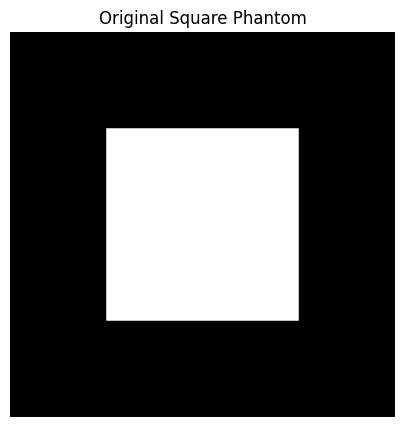

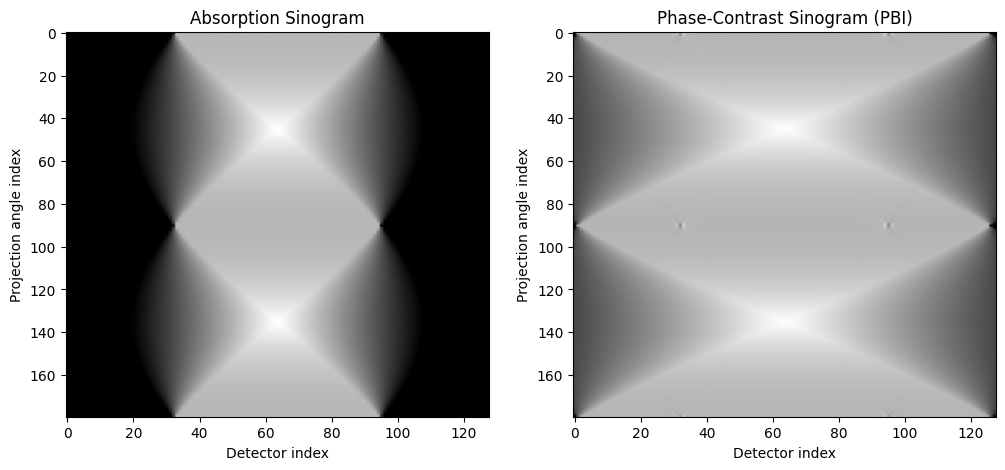

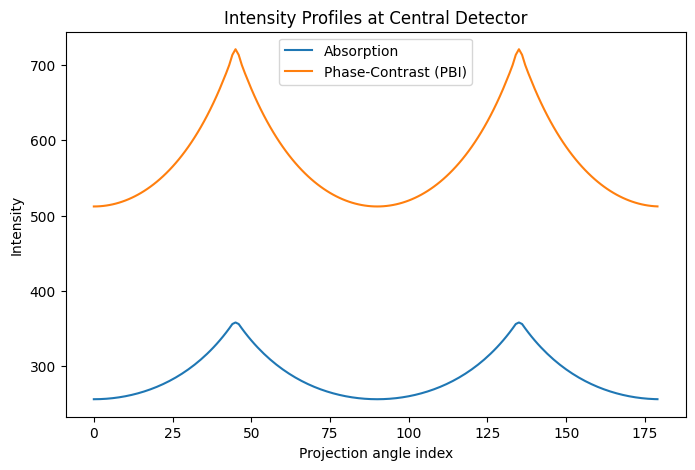

In [ ]:
import os
import math
import numpy as np
import astra
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift

# --------------------- Parameters --------------------
N_sensors = 128
n = 180
sensorWidth_cm = 0.08
objXDim_cm = 10.0
detectorLength_cm = sensorWidth_cm * N_sensors

distance_objSource_cm = 40.0
distance_objDetector_cm = 40.0

objXDim = 512
scale = objXDim / objXDim_cm

# Conversions to pixels
sensorWidth = sensorWidth_cm * scale
detectorLength = detectorLength_cm * scale
distance_objSource = distance_objSource_cm * scale
distance_objDetector = distance_objDetector_cm * scale

output_folder = 'sinograms_out'
os.makedirs(output_folder, exist_ok=True)

angles_rad = np.linspace(0.0, math.pi, n, endpoint=False)

# --------------------- Shape Generation ---------------------
def create_shape(shape_type='square', objXDim=512, scale=51.2):
    img = np.zeros((objXDim, objXDim), dtype=np.float32)
    cx, cy = objXDim // 2, objXDim // 2

    if shape_type == 'square':
        side_px = int(10 * scale)
        half = side_px // 4
        img[cy - half:cy + half, cx - half:cx + half] = 1.0
    elif shape_type == 'triangle':
        side_px = int(10 * scale)
        height = int(np.sqrt(3)/2 * side_px)
        for y in range(height):
            width = int((y / height) * side_px)
            x0 = cx - width // 2
            x1 = cx + width // 2
            yy = cy + height//2 - y
            if 0 <= yy < objXDim:
                img[yy, x0:x1] = 1.0
    elif shape_type == 'circle':
        r_px = int(5 * scale)
        Y, X = np.ogrid[:objXDim, :objXDim]
        mask = (X - cx)**2 + (Y - cy)**2 <= r_px**2
        img[mask] = 1.0
    else:
        raise ValueError("shape_type must be 'square', 'triangle', or 'circle'")
    return img

shape_type = 'square'
P = create_shape(shape_type, objXDim, scale)

plt.figure(figsize=(5,5))
plt.title(f'Original {shape_type.capitalize()} Phantom')
plt.imshow(P, cmap='gray')
plt.axis('off')
plt.show()

# --------------------- ASTRA Geometries ---------------------
proj_geom = astra.create_proj_geom(
    'parallel', sensorWidth, N_sensors, angles_rad, distance_objSource, distance_objDetector)
vol_geom = astra.create_vol_geom(objXDim, objXDim, -objXDim/2.0, objXDim/2.0, -objXDim/2.0, objXDim/2.0)

# --------------------- Generate Absorption Sinogram ---------------------
use_cuda = astra.astra.use_cuda()
vol_id = astra.data2d.create('-vol', vol_geom, P)
sino_id = astra.data2d.create('-sino', proj_geom)

if use_cuda:
    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    cfg = astra.astra_dict('FP_CUDA')
else:
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    cfg = astra.astra_dict('FP')

cfg['ProjectorId'] = proj_id
cfg['VolumeDataId'] = vol_id
cfg['ProjectionDataId'] = sino_id
fp_id = astra.algorithm.create(cfg)
astra.algorithm.run(fp_id)
abs_sino = astra.data2d.get(sino_id)

astra.algorithm.delete(fp_id)
astra.projector.delete(proj_id)
astra.data2d.delete(vol_id)
astra.data2d.delete(sino_id)

# --------------------- Phase-Contrast Simulation (PBI) ---------------------
def propagate_phase_contrast(img, wavelength=0.02, z=1000.0, dx=1.0):
    """Simple PBI phase contrast using TIE in Fourier space"""
    Nx, Ny = img.shape
    fx = np.fft.fftfreq(Nx, dx)
    fy = np.fft.fftfreq(Ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    H = np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))
    U0 = np.exp(1j * img)  # assume phase = img, amplitude=1
    U1 = ifft2(fft2(U0) * H)
    I = np.abs(U1)**2
    return I

P_phase = propagate_phase_contrast(P, wavelength=0.02, z=1000.0, dx=1.0)

# --------------------- Generate Sinogram for Phase-Contrast ---------------------
vol_id_phase = astra.data2d.create('-vol', vol_geom, P_phase)
sino_id_phase = astra.data2d.create('-sino', proj_geom)

if use_cuda:
    proj_id_phase = astra.create_projector('cuda', proj_geom, vol_geom)
    cfg_phase = astra.astra_dict('FP_CUDA')
else:
    proj_id_phase = astra.create_projector('line', proj_geom, vol_geom)
    cfg_phase = astra.astra_dict('FP')

cfg_phase['ProjectorId'] = proj_id_phase
cfg_phase['VolumeDataId'] = vol_id_phase
cfg_phase['ProjectionDataId'] = sino_id_phase
fp_id_phase = astra.algorithm.create(cfg_phase)
astra.algorithm.run(fp_id_phase)
phase_sino = astra.data2d.get(sino_id_phase)

astra.algorithm.delete(fp_id_phase)
astra.projector.delete(proj_id_phase)
astra.data2d.delete(vol_id_phase)
astra.data2d.delete(sino_id_phase)

# --------------------- Plot Sinograms ---------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Absorption Sinogram')
plt.imshow(abs_sino, cmap='gray', aspect='auto')
plt.xlabel('Detector index')
plt.ylabel('Projection angle index')

plt.subplot(1,2,2)
plt.title('Phase-Contrast Sinogram (PBI)')
plt.imshow(phase_sino, cmap='gray', aspect='auto')
plt.xlabel('Detector index')
plt.ylabel('Projection angle index')
plt.show()

# --------------------- Intensity Profiles ---------------------
detector_idx = N_sensors//2
plt.figure(figsize=(8,5))
plt.plot(abs_sino[:, detector_idx], label='Absorption')
plt.plot(phase_sino[:, detector_idx], label='Phase-Contrast (PBI)')
plt.title('Intensity Profiles at Central Detector')
plt.xlabel('Projection angle index')
plt.ylabel('Intensity')
plt.legend()
plt.show()
